<a href="https://colab.research.google.com/github/jhlopesalves/data-science-notebooks/blob/main/Python/projects/titanic/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Machine Learning from Disaster

## Dataset Description

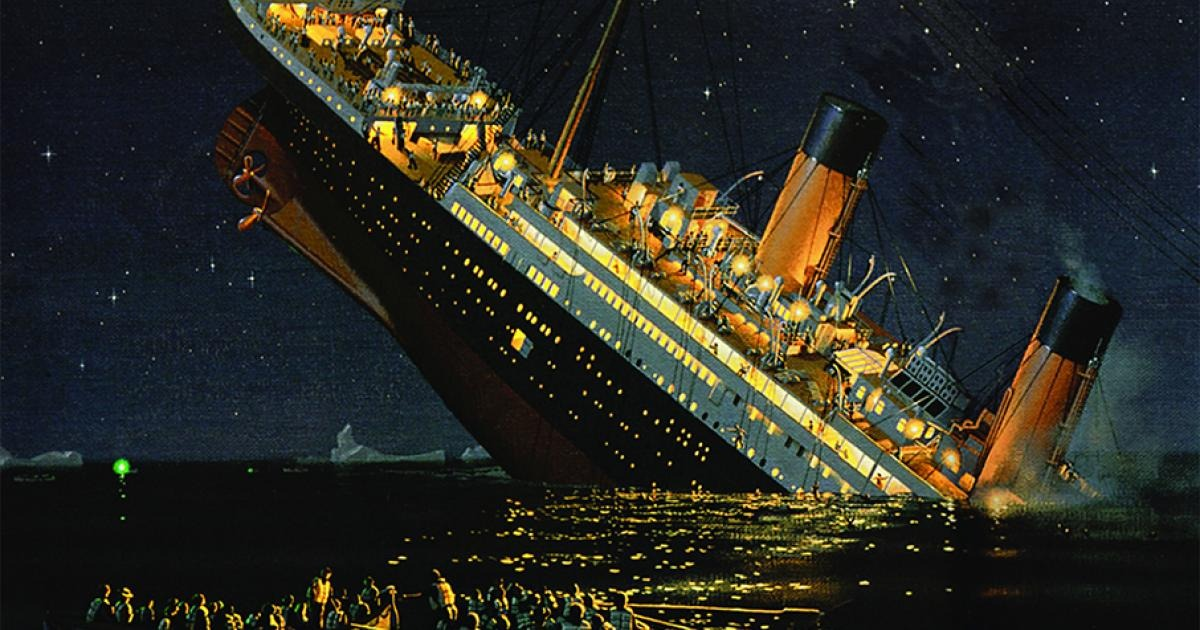

### Overview
The data for this task is split into three files:

- **Training set** (`train.csv`): This dataset is used to build your machine learning models. It includes the outcome (ground truth) for each passenger, indicating whether they survived or not. It contains features like gender, class, and others. You can also engineer new features from the existing ones.
- **Test set** (`test.csv`): This dataset is used to evaluate the performance of your model on unseen data. It does not include the ground truth for survival. Your task is to predict the survival outcome for each passenger in this set.
- **Gender submission** (`gender_submission.csv`): This file is an example submission in the correct format. It assumes all female passengers survived and all male passengers did not.

### Data Dictionary
This table describes the different variables (features) in the dataset:

| Variable   | Definition                  | Key                                                                 |
|------------|-----------------------------|---------------------------------------------------------------------|
| survival  | Survival                    | 0 = No, 1 = Yes                                                    |
| pclass    | Ticket class                | 1 = 1st, 2 = 2nd, 3 = 3rd                                          |
| sex       | Sex                         | male or female                                                      |
| Age       | Age in years                | Can be fractional if less than 1. Estimated ages are in the form xx.5. |
| sibsp     | # of siblings/spouses aboard| Number of siblings or spouses aboard. Sibling = brother, sister, stepbrother, stepsister. Spouse = husband, wife (mistresses and fiancés ignored). |
| parch     | # of parents/children aboard| Number of parents or children aboard. Parent = mother, father. Child = daughter, son, stepdaughter, stepson. Some children traveled only with a nanny, so parch=0 for them. |
| ticket    | Ticket number               |                                                                     |
| fare      | Passenger fare              |                                                                     |
| cabin     | Cabin number                |                                                                     |
| embarked  | Port of Embarkation         | C = Cherbourg, Q = Queenstown, S = Southampton                      |

### Variable Notes

- **pclass**: A proxy for socio-economic status (SES)
  - 1st = Upper Class
  - 2nd = Middle Class
  - 3rd = Lower Class

## Getting Started

To begin, you can load the `train.csv` and `test.csv` files into pandas DataFrames to explore the data and start building your survival prediction model.

Once loaded, you can start exploring the data using methods like `.head()`, `.info()`, and `.describe()` to understand its structure, data types, and summary statistics. Good luck!

In [ ]:
# Ignore warnings for a cleaner notebook
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

# Load the datasets
train_url = "https://raw.githubusercontent.com/jhlopesalves/data-science-notebooks/refs/heads/main/Python/projects/titanic/data/train.csv"
train_df = pd.read_csv(train_url)
test_url = "https://raw.githubusercontent.com/jhlopesalves/data-science-notebooks/refs/heads/main/Python/projects/titanic/data/test.csv"
test_df = pd.read_csv(test_url)
gender_url = "https://raw.githubusercontent.com/jhlopesalves/data-science-notebooks/refs/heads/main/Python/projects/titanic/data/gender_submission.csv"
submission_df = pd.read_csv(gender_url)  # To get PassengerId for submission

# Combine train and test sets for consistent preprocessing
# We store the original sizes to split them back later
train_size = len(train_df)
combined_df = pd.concat([train_df.drop("Survived", axis=1), test_df], ignore_index=True)

print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)
print("Combined data shape:", combined_df.shape)

# Store the target variable separately
y_train = train_df["Survived"]

Training data shape: (891, 12)
Testing data shape: (418, 11)
Combined data shape: (1309, 11)


In [ ]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 2. Exploratory Data Analysis (EDA)

Before we can build a predictive model, we must first understand the data we are working with. Exploratory Data Analysis (EDA) is the process of using summary statistics and visualizations to build an initial mental model of the dataset.

In this section, we will:
- **Inspect Data Types and Non-Null Counts:** Using `.info()`, we'll get a high-level overview of each feature, its data type (e.g., integer, float, object), and the number of non-null values. This is our first step in identifying missing data.
- **Identify Missing Values:** We'll explicitly count the `null` values in each column of the combined dataset. This will highlight which features require imputation or other forms of cleaning. As we can see, `Age`, `Fare`, `Cabin`, and `Embarked` all contain missing data that must be addressed.
- **Analyze Summary Statistics:** With `.describe()`, we will examine the central tendency, dispersion, and shape of the numerical features' distribution. For categorical features, we will look at counts, unique values, and the most frequent categories. This helps us spot anomalies and understand the scale of each variable.

In [ ]:
print(train_df.info())
print(test_df.info())
print(train_df.describe())
print(train_df.describe(include=["O"]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

## Feature Analysis

We visualise key features against survival outcome to find predictive signal.


In [ ]:
# Initial data inspection
print("Data Information:")
combined_df.info()

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


In [ ]:
print("Missing Values:")
print(combined_df.isnull().sum())

Missing Values:
PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


### Visualizing Key Relationships

Visualizations are powerful tools for uncovering patterns that are not obvious from summary statistics alone. We will now create a series of plots to explore the relationship between key features and the `Survived` target variable. This analysis will directly inform our feature engineering decisions by revealing which variables are most predictive.

-   **Survival by Sex:** We expect gender to be a strong predictor, as the "women and children first" protocol was a known maritime tradition.
-   **Survival by Passenger Class (Pclass):** Passenger class serves as a proxy for socio-economic status. It is likely that first-class passengers had better access to lifeboats.
-   **Survival by Port of Embarkation (Embarked):** The port where a passenger boarded might correlate with their social class or cabin location, indirectly influencing their survival chances.
-   **Age Distribution of Survivors:** We will compare the age distributions for those who survived versus those who did not. This may reveal specific age groups with higher or lower survival rates.

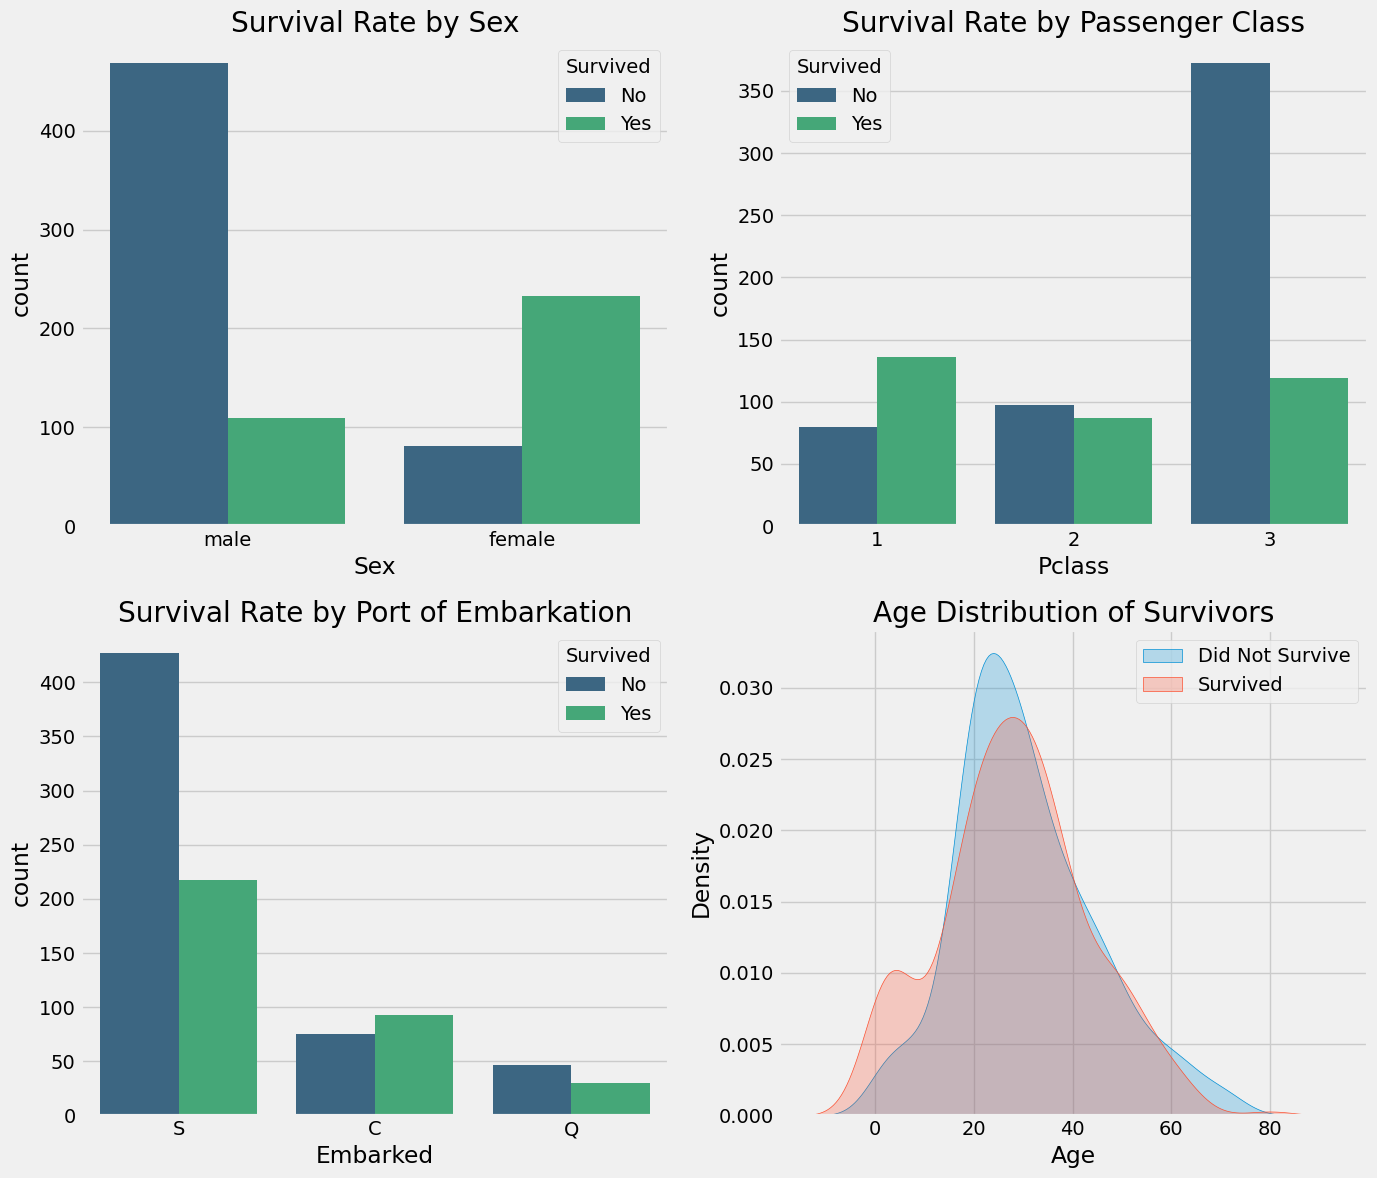

In [ ]:
# Visualise survival rates based on key categorical features
plt.style.use("fivethirtyeight")
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Survival by Sex
sns.countplot(x="Sex", hue="Survived", data=train_df, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title("Survival Rate by Sex")
axes[0, 0].legend(title="Survived", labels=["No", "Yes"])

# Survival by Pclass
sns.countplot(
    x="Pclass", hue="Survived", data=train_df, ax=axes[0, 1], palette="viridis"
)
axes[0, 1].set_title("Survival Rate by Passenger Class")
axes[0, 1].legend(title="Survived", labels=["No", "Yes"])

# Survival by Embarked
sns.countplot(
    x="Embarked", hue="Survived", data=train_df, ax=axes[1, 0], palette="viridis"
)
axes[1, 0].set_title("Survival Rate by Port of Embarkation")
axes[1, 0].legend(title="Survived", labels=["No", "Yes"])

# Age distribution by survival
sns.kdeplot(
    train_df.loc[train_df["Survived"] == 0, "Age"].dropna(),
    label="Did Not Survive",
    ax=axes[1, 1],
    shade=True,
)
sns.kdeplot(
    train_df.loc[train_df["Survived"] == 1, "Age"].dropna(),
    label="Survived",
    ax=axes[1, 1],
    shade=True,
)
axes[1, 1].set_title("Age Distribution of Survivors")
axes[1, 1].set_xlabel("Age")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 3. Feature Engineering & Data Cleaning

This is often the most impactful stage in a machine learning project. Raw data is rarely in an optimal format for modeling. Here, we will clean the dataset and create new features (feature engineering) to better capture the underlying patterns related to survival. Our strategy is guided by the insights gained during EDA.

Our key steps will be:
1.  **Extract Titles from Names:** The `Name` column contains titles (e.g., Mr., Mrs., Miss), which are strong indicators of age, gender, and social status. We will extract these titles to create a new `Title` feature.
2.  **Impute Missing Values:** We'll fill in missing `Embarked`, `Fare`, and `Age` data using logical strategies. For example, `Embarked` will be filled with the most common port, while `Age` will be imputed based on the median age for each passenger's `Title`.
3.  **Create Family-Based Features:** We will combine `SibSp` (siblings/spouses) and `Parch` (parents/children) to create a `FamilySize` feature. It's plausible that individuals traveling alone (`IsAlone`) or in very large families had different survival outcomes.
4.  **Bin Numerical Features:** Continuous variables like `Age` and `Fare` can sometimes be more powerful if grouped into discrete bins. This helps the model capture non-linear relationships. We will use quantile-based binning to create `AgeBin` and `FareBin`.
5.  **Clean Up Unused Columns:** We will drop the original columns that are now redundant or contain too much noise (e.g., `Name`, `Ticket`, `Cabin`).
6.  **Encode Categorical Features:** Machine learning models require numerical input. We will convert our categorical features (`Sex`, `Embarked`, `Title`) into a numerical format using one-hot encoding.

In [ ]:
# 1. Extract Title from Name
combined_df["Title"] = combined_df["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
# Consolidate rare titles into a 'Rare' category
rare_titles = [
    "Dr",
    "Rev",
    "Col",
    "Major",
    "Sir",
    "Lady",
    "Don",
    "Dona",
    "Jonkheer",
    "Capt",
    "Countess",
    "Mme",
    "Mlle",
    "Ms",
]
combined_df["Title"] = combined_df["Title"].replace(rare_titles, "Rare")

# 2. Impute missing Embarked (with the mode)
most_frequent_embarked = combined_df["Embarked"].mode()[0]
combined_df["Embarked"].fillna(most_frequent_embarked, inplace=True)

# 3. Impute missing Fare (with the median for its Pclass)
median_fare = combined_df.groupby("Pclass")["Fare"].transform("median")
combined_df["Fare"].fillna(median_fare, inplace=True)

# 4. Impute missing Age based on Title median
median_age_by_title = combined_df.groupby("Title")["Age"].transform("median")
combined_df["Age"].fillna(median_age_by_title, inplace=True)

# 5. Create FamilySize and IsAlone features
combined_df["FamilySize"] = combined_df["SibSp"] + combined_df["Parch"] + 1
combined_df["IsAlone"] = (combined_df["FamilySize"] == 1).astype(int)

# 6. Bin numerical features (Age and Fare)
combined_df["AgeBin"] = pd.qcut(combined_df["Age"], 4, labels=False)
combined_df["FareBin"] = pd.qcut(combined_df["Fare"], 4, labels=False)

# 7. Drop original columns that are no longer needed
features_to_drop = ["Name", "Age", "SibSp", "Parch", "Ticket", "Cabin", "Fare"]
combined_df.drop(columns=features_to_drop, inplace=True)

# 8. Convert categorical features to numerical using one-hot encoding
combined_df = pd.get_dummies(
    combined_df, columns=["Sex", "Embarked", "Title"], drop_first=True
)

print("Data after feature engineering:")
combined_df.head()

Data after feature engineering:


,PassengerId,Pclass,FamilySize,IsAlone,AgeBin,FareBin,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,3,2,0,0,0,True,False,True,False,True,False,False
1,2,1,2,0,3,3,False,False,False,False,False,True,False
2,3,3,1,1,1,1,False,False,True,True,False,False,False
3,4,1,2,0,2,3,False,False,True,False,False,True,False
4,5,3,1,1,2,1,True,False,True,False,True,False,False


## 4. Modeling and Submission

With a clean, engineered dataset, we can now train our predictive model. We will first split the `combined_df` back into its original training and testing sets.

For this task, a **Random Forest Classifier** is an excellent choice. As an ensemble model, it is robust, handles interactions between features well, and is less prone to overfitting than a single decision tree. We will configure it with a reasonable set of hyperparameters as a strong baseline.

After training the model on the full training dataset (`X_train` and `y_train`), we will use it to make survival predictions on the unseen test data (`X_test`). Finally, we will format these predictions into the required `submission.csv` format and inspect the feature importances to understand which variables our model found most predictive.

In [ ]:
# Split the data back into training and testing sets
X_train = combined_df.iloc[:train_size].drop("PassengerId", axis=1)
X_test = combined_df.iloc[train_size:].drop("PassengerId", axis=1)

# A robust Random Forest model
random_forest = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    criterion="gini",
)

# Train the model on the entire training data
random_forest.fit(X_train, y_train)

# Make predictions on the test data
predictions = random_forest.predict(X_test)

# Create the submission file
submission = pd.DataFrame(
    {"PassengerId": test_df["PassengerId"], "Survived": predictions}
)

# Save the submission file
submission.to_csv("titanic_submission.csv", index=False)

print("Submission file created successfully!")
print(submission.head())

# Optional: Feature Importance
importances = pd.DataFrame(
    {
        "feature": X_train.columns,
        "importance": np.round(random_forest.feature_importances_, 3),
    }
)
importances = importances.sort_values("importance", ascending=False).set_index(
    "feature"
)
print("Feature Importances:")
print(importances)

Submission file created successfully!
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
Feature Importances:
            importance
feature               
Sex_male         0.259
Title_Mr         0.218
Pclass           0.146
FamilySize       0.091
Title_Miss       0.064
FareBin          0.064
Title_Mrs        0.056
AgeBin           0.041
Embarked_S       0.022
IsAlone          0.016
Title_Rare       0.012
Embarked_Q       0.011


## 5. Model Evaluation

Generating a submission file is the final step for the competition, but it doesn't tell us how well our model is performing locally. To get a reliable estimate of our model's accuracy on unseen data, we use **cross-validation**.

Here, we will employ **Stratified K-Fold Cross-Validation**. This technique splits the training data into 'k' folds (we'll use 5), ensuring that each fold has the same proportion of survivors and non-survivors as the original dataset. The model is then trained on k-1 folds and validated on the remaining fold. This process is repeated 'k' times, and the average accuracy provides a robust estimate of our model's performance.

In [ ]:
from sklearn.model_selection import cross_val_score

# We re-initialise the same Random Forest model
random_forest = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    criterion="gini",
)

# Use StratifiedKFold for cross-validation to maintain the proportion of survived/not survived in each fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(
    random_forest, X_train, y_train, cv=cv_strategy, scoring="accuracy"
)

# Print the results
print(f"Cross-Validation Accuracy Scores: {np.round(cv_scores, 4)}")
print(f"Average Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of Scores: {np.std(cv_scores):.4f}")

Cross-Validation Accuracy Scores: [0.8268 0.8202 0.8146 0.8258 0.8427]
Average Cross-Validation Accuracy: 0.8260
Standard Deviation of Scores: 0.0094


### Confusion Matrix and Classification Report

While cross-validation gives us an overall accuracy score, we often need a more detailed breakdown of performance. To achieve this, we'll split our training data into a training subset and a validation subset. We'll then train the model on the new training subset and evaluate its predictions on the validation set.

-   **Confusion Matrix:** This table provides a clear visualization of our model's predictions, showing the counts of True Positives, True Negatives, False Positives, and False Negatives. It helps us understand what kind of errors our model is making.
-   **Classification Report:** This report provides key metrics like **Precision** (of all positive predictions, how many were correct?) and **Recall** (of all actual positives, how many did we find?). These metrics give us a deeper insight into the model's performance for each class (Survived vs. Did Not Survive).

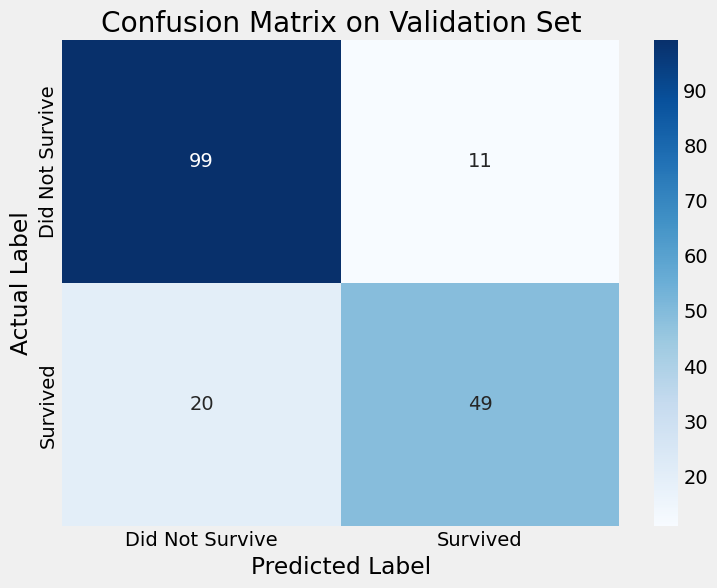


Classification Report:
                 precision    recall  f1-score   support

Did Not Survive       0.83      0.90      0.86       110
       Survived       0.82      0.71      0.76        69

       accuracy                           0.83       179
      macro avg       0.82      0.81      0.81       179
   weighted avg       0.83      0.83      0.82       179



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Split the training data to create a validation set
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Train the model on the smaller training portion
random_forest.fit(X_train_split, y_train_split)

# Make predictions on the validation set
validation_predictions = random_forest.predict(X_val_split)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val_split, validation_predictions)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Did Not Survive", "Survived"],
    yticklabels=["Did Not Survive", "Survived"],
)
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix on Validation Set")
plt.show()

# Generate the classification report
print("\nClassification Report:")
print(
    classification_report(
        y_val_split,
        validation_predictions,
        target_names=["Did Not Survive", "Survived"],
    )
)

### Distribution of Final Predictions

Finally, let's visualize the distribution of our model's predictions on the official test set. This plot shows the total number of passengers our model predicts will survive versus those who will not. It serves as a final sanity check to ensure the predictions are reasonably distributed before submitting them to Kaggle.

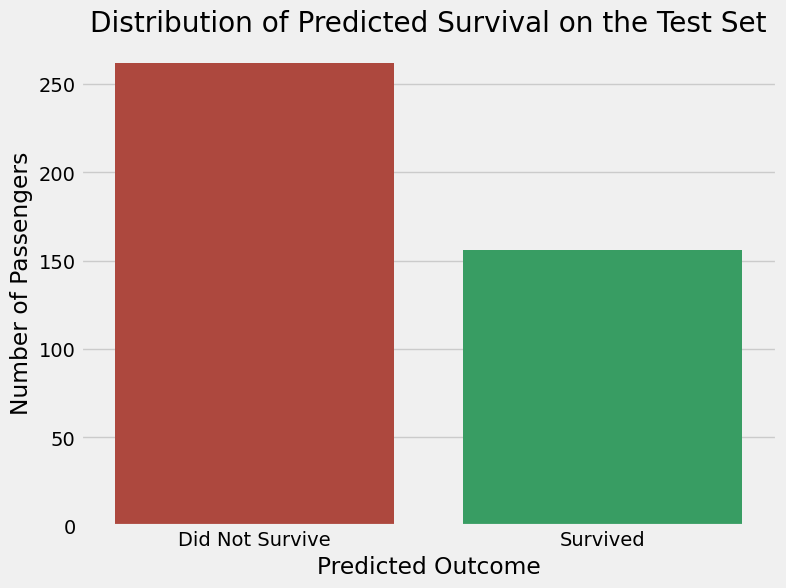

In [ ]:
# The 'predictions' variable holds our final predictions on the test set from the previous response
submission["Survived_Label"] = submission["Survived"].map(
    {0: "Did Not Survive", 1: "Survived"}
)

plt.figure(figsize=(8, 6))
sns.countplot(x="Survived_Label", data=submission, palette=["#c0392b", "#27ae60"])
plt.title("Distribution of Predicted Survival on the Test Set")
plt.xlabel("Predicted Outcome")
plt.ylabel("Number of Passengers")
plt.show()